In [1]:
import pandas as pd
import numpy as np
import pystan
import pandas as pd
import numpy as np
import time
import diagnostics
from itertools import chain
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import StandardScaler

import density_intervals as di
import seaborn as sns

import warnings; warnings.simplefilter('ignore')

In [2]:
path = '../big_data/sneaker_transactions.csv'

In [3]:
def MakeTimeSeriesData(path):
    data = pd.read_csv(path, index_col=0)
    data.createdAt = data.createdAt.str.replace('T', ' ')
    
    data.createdAt = data.createdAt.str.split(' ').str[0]
    data.createdAt = pd.to_datetime(data.createdAt)

    time_data = data.loc[:, ('sku', 'createdAt')]
    ordered_data = time_data.sort_values('createdAt')

    daily_count = ordered_data.groupby('createdAt').count()
    daily_count['date'] = daily_count.index
    daily_count = daily_count.reset_index().loc[:, ('sku', 'date')]
    daily_count.columns = ['volume', 'date']
    daily_count.date = pd.to_datetime(daily_count.date)
    
    return(daily_count)

In [4]:
daily_volume = MakeTimeSeriesData(path)

In [5]:
def EngineerFeatures(daily_volume, days_rolling, days_forward):
    over_threshold = daily_volume[daily_volume['volume'] > 50]
    
    # Extract date information from transaction data

    over_threshold['day_of_week'] = over_threshold['date'].dt.day_name()
    over_threshold['month'] = over_threshold['date'].dt.month_name()
    over_threshold['year'] = over_threshold['date'].dt.year
    over_threshold['year'] = over_threshold['year'].astype('category')
    
    # Calculate moving average metrics
    
    over_threshold['rolling_mean_week'] = over_threshold['volume'].rolling(days_rolling).mean()
    over_threshold['rolling_median_week'] = over_threshold['volume'].rolling(days_rolling).median()
    over_threshold['rolling_max_week'] = over_threshold['volume'].rolling(days_rolling).max()
    over_threshold['projected_volume'] = over_threshold.volume.shift(-days_forward)
    
    # Create predictor for holidays

    dr = pd.date_range(start='2017-02-16', end='2019-06-16')
    df = pd.DataFrame()
    df['Date'] = dr

    cal = calendar()
    holidays = cal.holidays(start=dr.min(), end=dr.max())
    holidays = list(holidays.strftime("%Y-%m-%d"))
    non_federal_holidays = ['2017-10-31', '2018-10-31', '2017-11-24', '2017-11-25', '2017-11-26', '2018-11-23', 
                            '2018-11-24', '2018-11-25', '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
                            '2017-12-30', '2018-12-26', '2018-12-27', '2017-12-28', '2018-12-29', '2017-12-30']
    
    holidates = holidays + non_federal_holidays 

    over_threshold['holiday'] = over_threshold['date'].isin(non_federal_holidays).astype(int)
    
    # Load sneaker releases data

    sneaker_releases = pd.read_csv('sneaker_metadata_collab.csv')
    sneaker_releases['date'] = sneaker_releases.releaseDate.str.split(' ').str[0]
    
    # Get special collaborations
    
    sneaker_releases['is_retro'] = sneaker_releases.model.str.contains('Retro').astype(int)
    sneaker_releases['is_yeezy'] = sneaker_releases.model.str.contains('Yeezy').astype(int)
    sneaker_releases['is_pharrell'] = sneaker_releases.name.str.contains('Pharrell').astype(int)
    
    special_releases = sneaker_releases.loc[:, ('is_retro', 'is_yeezy', 'is_pharrell', 'date')]
    
    special_releases = special_releases.groupby('date').sum()
    special_releases['date'] = special_releases.index
    special_releases = special_releases.reset_index(drop=True)
    special_releases.date = pd.to_datetime(special_releases.date)
    
    over_threshold = pd.merge(over_threshold, special_releases, how = 'left', on = 'date')
    over_threshold.is_retro = over_threshold.is_retro.fillna(0)
    over_threshold.is_yeezy = over_threshold.is_yeezy.fillna(0)
    over_threshold.is_pharrell = over_threshold.is_pharrell.fillna(0)
    over_threshold['is_retro'] = over_threshold['is_retro'].shift(-days_forward)
    over_threshold['is_yeezy'] = over_threshold['is_yeezy'].shift(-days_forward)
    over_threshold['is_pharrell'] = over_threshold['is_pharrell'].shift(-days_forward)
    
    # Get total releases on a day

    release_dates = sneaker_releases.loc[:, ('brand', 'releaseDate')]

    release_dates.releaseDate = release_dates.releaseDate.str.split(' ').str[0]
    
    grouped_release = release_dates.groupby('releaseDate').count()
    grouped_release['date'] = grouped_release.index
    grouped_release.date = pd.to_datetime(grouped_release.date)
    grouped_release = grouped_release.reset_index(drop=True)
    grouped_release.columns = ['total_release', 'date']
    
    merged_release = pd.merge(over_threshold, grouped_release, how = 'left', on='date')
    merged_release.total_release = merged_release.total_release.fillna(0)
    
    merged_release['total_release'] = merged_release['total_release'].shift(-days_forward)

       
    return merged_release

    # shelved predictors
    #     over_threshold['rolling_sd_week'] = over_threshold['volume'].rolling(days_rolling).std()
    #     over_threshold['day_of_year'] = over_threshold['date'].dt.dayofyear
    #     over_threshold['month'] = over_threshold['date'].dt.month
    #     over_threshold['day_of_week'] = over_threshold['date'].dt.dayofweek
    # model_df['rolling_releases'] = model_df.total_release.iloc[::-1].rolling(5, min_periods=0).sum().iloc[::-1]
    # model_df['rolling_holiday'] = model_df.holiday.iloc[::-1].rolling(7, min_periods=0).sum().iloc[::-1]
    #     merged_release['total_release'] = np.where(merged_release['total_release'] > 0, 1, 0)  

In [6]:
model_df = EngineerFeatures(daily_volume, 5, 3)

In [7]:
cat_bool = ['day_of_week', 'month', 'year', 'holiday', 'date', 'is_retro', 'is_yeezy', 'is_pharrell']
cat_df = model_df.loc[:, (cat_bool)]

In [8]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = model_df.select_dtypes(include=numerics)

In [9]:
tmp = newdf.loc[:, ('volume', 'rolling_mean_week', 'rolling_median_week', 
                    'rolling_max_week', 'projected_volume')]


In [10]:
scaler = StandardScaler() 
scaled_values = scaler.fit_transform(tmp) 
tmp.loc[:,:] = scaled_values

In [11]:
model_df = pd.concat([cat_df, tmp], axis=1, sort=False)


In [12]:
model_df.date = pd.to_datetime(model_df.date)

collab_releases = pd.read_csv('sneaker_metadata_collab.csv')

collab_dates = collab_releases.loc[:, ('collab', 'releaseDate')]

collab_dates['date'] = collab_dates.releaseDate.str.split(' ').str[0]
collab_dates = collab_dates.groupby('date').sum()
collab_dates['date'] = collab_dates.index
collab_dates = collab_dates.reset_index(drop=True)
collab_dates.date = pd.to_datetime(collab_dates.date)

model_df = pd.merge(model_df, collab_dates, how = 'left', on = 'date')

model_df.collab = model_df.collab.fillna(0)
model_df['collab'] = model_df['collab'].shift(-7)

In [13]:
def SplitTrainTest(model_df, train_pct):
    
    model_df = model_df[model_df['date'] > '2017-10-30']
    data = model_df.drop("date", axis=1)
    
    rf_df = pd.get_dummies(data)
    rf_df = rf_df.dropna()
    rf_df = rf_df.reset_index(drop = True)

    # Labels are the values we want to predict
    labels = np.array(rf_df['projected_volume'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features= rf_df.drop('projected_volume', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)
    
    split_axis = round(len(model_df) * train_pct)
    
    train = rf_df[:split_axis]
    test = rf_df[split_axis:-6]

    train_labels = np.array(train['projected_volume'])
    train_features = train.drop('projected_volume', axis = 1)

    test_labels = np.array(test['projected_volume'])
    test_features = test.drop('projected_volume', axis = 1)

    return train_features, train_labels, test_features, test_labels

In [14]:
train_features, train_labels, test_features, test_labels = SplitTrainTest(model_df, train_pct = 0.9)

In [15]:
lin_reg_normal = """
    /* Spec for robust linear regression model */
    data {                                 
        int<lower=0> N;                     // count of observations
        int<lower=0> K;                     // count of features
        matrix[N, K] X;                     // feature matrix
        real y[N];          // target
    }
    parameters {
        real alpha;                         // constant
        vector[K] beta;                     // feature coefficients
        real<lower=0> sigma;
    }
    model { 
        alpha ~ normal(0,3);              // prior
        beta ~ normal(0,3);              // prior
        y ~ normal(alpha + X * beta, sigma);         // likelihood
    }
    generated quantities {}
    """

In [16]:
stan_datadict = {}
stan_datadict['N'] = train_features.shape[0]
stan_datadict['K'] = train_features.shape[1]
stan_datadict['X'] = train_features.values
stan_datadict['y'] = train_labels

model = pystan.StanModel(model_code=lin_reg_normal)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4fb3e31160fe1168ad08b1600c5fdef2 NOW.


In [17]:
fit = model.sampling(data=stan_datadict,
                warmup=250,
                iter = 1000, 
                verbose = True,
                control={'max_treedepth': 15})

In [18]:
print(diagnostics.check_treedepth(fit))
print(diagnostics.check_energy(fit))
print(diagnostics.check_div(fit))

465 of 3000 iterations saturated the maximum tree depth of 10 (15.5%)
  Run again with max_depth set to a larger value to avoid saturation
None
E-BFMI indicated no pathological behavior
None
0.0 of 3000 iterations ended with a divergence (0.0%)
None


In [19]:
b = fit.extract(['alpha'])['alpha'].mean()
w = fit.extract(['beta'])['beta'].mean(axis=0)

In [20]:
print(b)
print(w)

0.05571345446702548
[ 0.02676612  0.10335584  0.33569749 -0.04936877  0.16411145  0.45776265
 -0.05238406 -0.20148958 -0.10898206  0.11704512 -0.04105931  0.08905916
 -0.26730634  0.2157824   0.01755311 -0.40000191 -0.05925182  0.86037792
 -0.3128026  -0.55710869 -0.0929176  -0.24369295 -0.44751576 -0.14884884
  0.70166039  0.09880184  0.26532872 -1.1214784   0.02407739  1.10330872]


In [21]:
mean_weights = pd.DataFrame(w)

In [22]:
train_features.columns

Index(['holiday', 'is_retro', 'is_yeezy', 'is_pharrell', 'volume',
       'rolling_mean_week', 'rolling_median_week', 'rolling_max_week',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'month_April', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'year_2017', 'year_2018',
       'year_2019'],
      dtype='object')

In [23]:
predictions = test_features@w + b

In [24]:
numer_test_features = test_features.loc[:, ('volume', 'rolling_mean_week', 'rolling_median_week', 
                    'rolling_max_week')]


In [25]:
unscale_test = pd.concat([numer_test_features, predictions],axis=1)
unscale_test.columns = ['volume', 'rolling_mean_week', 'rolling_median_week', 'rolling_max_week', 'projected_volume']
unscaled_predictions = scaler.inverse_transform(unscale_test)
unscale_test.loc[:,:] = unscaled_predictions
unscaled_predictions = unscale_test.projected_volume

In [26]:
test_labels_df = pd.Series(test_labels)
test_labels_df.index = numer_test_features.index
unscale_labels = pd.concat([numer_test_features, test_labels_df],axis=1)
unscale_labels.columns = ['volume', 'rolling_mean_week', 'rolling_median_week', 'rolling_max_week', 'projected_volume']

In [27]:
unscaled_test_labels = scaler.inverse_transform(unscale_labels)
unscale_labels.loc[:,:] = unscaled_test_labels

In [28]:
observed = unscale_labels.projected_volume
persistance_prediction = unscale_labels.volume

[Text(0, 0.5, 'Observed'), Text(0.5, 0, 'Predicted')]

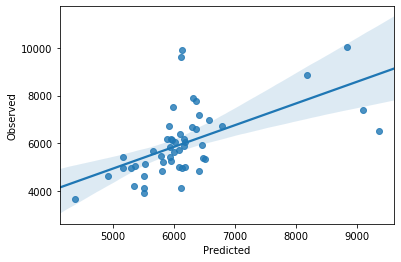

In [29]:
fig = sns.regplot(x=unscaled_predictions, y=observed)
fig.set(xlabel='Predicted', ylabel='Observed')

In [30]:
observ_predict = fig.get_figure()
observ_predict.savefig('./figures/observed_vs_predicted.png', dpi=400) 

In [31]:
print('Mean Absolute Percentage Error - Baseline:', round(np.mean(np.abs((observed - persistance_prediction) / observed)) * 100))
print('Mean Absolute Percentage Error - Bayes:', round(np.mean(np.abs((observed - unscaled_predictions) / observed)) * 100))


Mean Absolute Percentage Error - Baseline: 23.0
Mean Absolute Percentage Error - Bayes: 14.0


In [32]:
samples = fit.extract()

In [33]:
beta = samples['beta']

In [34]:
col_names = test_features.columns
weights = pd.DataFrame(beta)
weights.columns = col_names
melted_weights = weights.melt()

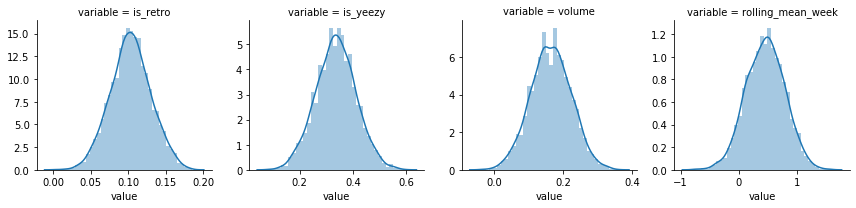

In [35]:
desired_features = ['volume', 'rolling_mean_week', 'is_retro', 'is_yeezy']
posterior_features = melted_weights[melted_weights['variable'].isin(desired_features)]
g = sns.FacetGrid(posterior_features, col='variable', sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.savefig('./figures/variable_posteriors.png', dpi = 400)

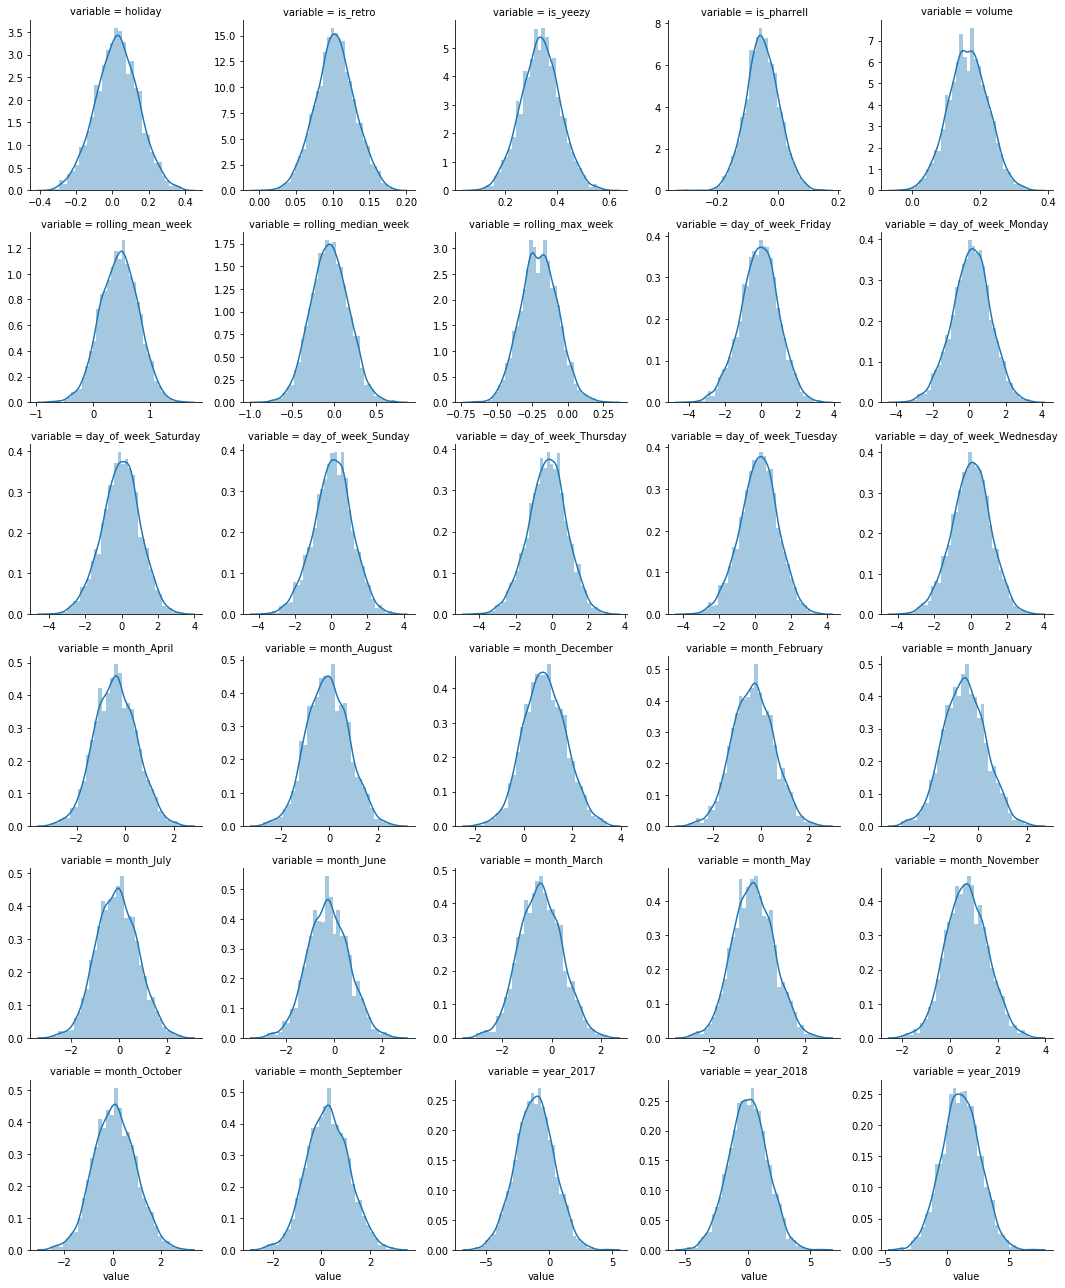

In [36]:
a = sns.FacetGrid(melted_weights, col='variable', col_wrap=5, sharex=False, sharey=False)
a = a.map(sns.distplot, "value")

# Testing how to get posterior predictions

In [37]:
one_example = test_features.sample()

In [63]:
one_example.shape

(1, 30)

In [38]:
t_beta = beta.transpose()

In [39]:
prediction_interval = (one_example@t_beta).values

In [68]:
test = (t_one_example@beta).values

ValueError: Dot product shape mismatch, (30, 1) vs (3000, 30)

In [40]:
prediction_list = list(chain.from_iterable(prediction_interval))

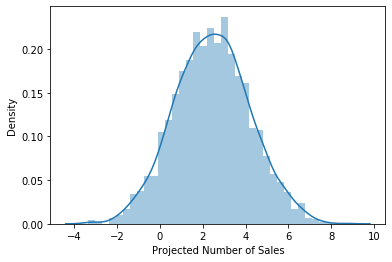

In [46]:
p = sns.distplot(prediction_interval)
p.set(xlabel='Projected Number of Sales', ylabel='Density')
p.figure.savefig('./figures/posterior_predictions.png', dpi = 400)

In [47]:
prediction_interval = (one_example@t_beta).values

for i in range(len(test_features)):
    one_day = test_features.iloc[i, :]
    prediction_interval = (one_example@t_beta + b).values
    samples_list = list(chain.from_iterable(prediction_interval))
    intervals, x, y, modes = di.hpd_grid(samples_list, alpha=0.025)

In [48]:
def PredictIntervals(index):

    one_day = test_features.iloc[index, :]
    prediction_interval = (one_example@t_beta + b).values
    samples_list = list(chain.from_iterable(prediction_interval))
    intervals, x, y, modes = di.hpd_grid(samples_list, alpha=0.025)
    low_interval = intervals[0][0].astype(float)
    high_interval = intervals[0][1].astype(float)
    
    return low_interval, high_interval

In [49]:
one_day = test_features.iloc[20, :]
prediction_interval = (one_example@t_beta + b).values
samples_list = list(chain.from_iterable(prediction_interval))
intervals, x, y, modes = di.hpd_grid(samples_list, alpha=0.025)
low_interval = intervals[0][0].astype(float)
high_interval = intervals[0][1].astype(float)
    

In [50]:
test_features.head()

,holiday,is_retro,is_yeezy,is_pharrell,volume,rolling_mean_week,rolling_median_week,rolling_max_week,day_of_week_Friday,day_of_week_Monday,...,month_July,month_June,month_March,month_May,month_November,month_October,month_September,year_2017,year_2018,year_2019
538,0,0.0,0.0,0.0,1.086488,1.220421,1.379674,0.99275,0,1,...,0,0,0,0,0,0,0,0,0,1
539,0,0.0,0.0,0.0,2.494331,1.464906,1.379674,1.70999,0,0,...,0,0,0,0,0,0,0,0,0,1
540,0,0.0,1.0,0.0,1.183897,1.383442,1.320111,1.70999,0,0,...,0,0,0,0,0,0,0,0,0,1
541,0,0.0,0.0,0.0,0.963744,1.325673,1.213850,1.70999,0,0,...,0,0,0,0,0,0,0,0,0,1
542,0,0.0,0.0,0.0,1.121433,1.435333,1.251971,1.70999,1,0,...,0,0,0,0,0,0,0,0,0,1


In [51]:
low = []
high = []

for i in range(len(test_features)):
    low_prediction, high_prediction = PredictIntervals(i)
    low.append(low_prediction)
    high.append(high_prediction)

In [52]:
samples_list = list(chain.from_iterable(prediction_interval))

https://github.com/aloctavodia/BAP

In [53]:
intervals, x, y, modes = hpd_grid(samples_list, alpha=0.025)

NameError: name 'hpd_grid' is not defined

##### intervals[0]